In [14]:
# Import Libraries
import os
import sys

import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
import seaborn as sns
from uncertainties import ufloat
import warnings


# Add the src directory to the path to import snowpyt_mechparams
sys.path.append('../src')
from snowpilot_utils import parse_sample_pits


In [3]:
# Parse all snowpit files from the data folder
all_pits = parse_sample_pits('data')


Successfully parsed 50278 files
Failed to parse 0 files


In [4]:
# Collect General Pit Info
pit_info = []

for pit in all_pits:
    pit_info_dict = {
        # User info
        'pit_id': pit.core_info.pit_id,
        # Location info
        'pit_near_avalanche': pit.core_info.location.pit_near_avalanche,
        'pit_near_avalanche_location': pit.core_info.location.pit_near_avalanche_location if pit.core_info.location.pit_near_avalanche_location else None,
        # Weak Layer
        'identified_layer_of_concern': any(layer.layer_of_concern is True for layer in pit.snow_profile.layers) if pit.snow_profile.layers else None,
        # Stability Tests
        'num_CT': len(pit.stability_tests.CT),
        'num_ECT': len(pit.stability_tests.ECT),
        'num_PST': len(pit.stability_tests.PST),
        # Snowpit info

    }
    pit_info.append(pit_info_dict)
    
pit_df = pd.DataFrame(pit_info)

#print(pit_df.head())


In [5]:
## Summary Stats

# Total Pits
print(f"Total Pits: {len(pit_df)}")

# Number of Pits Near Avalanches
pits_near_avalanches = pit_df[(pit_df['pit_near_avalanche'] == True)]
print(f"Number of Pits Near Avalanches: {len(pits_near_avalanches)}")

# Number of Pits on Crowns
pits_on_crowns = pit_df[pit_df['pit_near_avalanche_location'] == 'crown']
print(f"Number of Pits on Crowns: {len(pits_on_crowns)}")

# Number of Pits on Flanks
pits_on_flanks = pit_df[pit_df['pit_near_avalanche_location'] == 'flank']
print(f"Number of Pits on Flanks: {len(pits_on_flanks)}")

# Number of Pits on Crowns and Flanks
print(f"Number of Pits on Crowns and Flanks: {len(pits_on_crowns) + len(pits_on_flanks)}")

# Number of pits with identified layer of concern
pits_with_layer_of_concern = pit_df[pit_df['identified_layer_of_concern'] == True]
print(f"Number of pits with identified layer of concern: {len(pits_with_layer_of_concern)}")

# Number of Pits with CT results
pits_with_CT_results = pit_df[pit_df['num_CT'] > 0]
print(f"Number of Pits with CT results: {len(pits_with_CT_results)}")

# Number of CT results 
print(f"Number of CT results: {sum(pit_df['num_CT'])}")

# Number of Pits with ECT results
pits_with_ECT_results = pit_df[pit_df['num_ECT'] > 0]
print(f"Number of Pits with ECT results: {len(pits_with_ECT_results)}")

# Number of ECT results
print(f"Number of ECT results: {sum(pit_df['num_ECT'])}")

# Number of Pits with PST results
pits_with_PST_results = pit_df[pit_df['num_PST'] > 0]
print(f"Number of Pits with PST results: {len(pits_with_PST_results)}")

# Number of PST results
print(f"Number of PST results: {sum(pit_df['num_PST'])}")


Total Pits: 50278
Number of Pits Near Avalanches: 1568
Number of Pits on Crowns: 795
Number of Pits on Flanks: 399
Number of Pits on Crowns and Flanks: 1194
Number of pits with identified layer of concern: 36408
Number of Pits with CT results: 28959
Number of CT results: 51599
Number of Pits with ECT results: 34327
Number of ECT results: 47684
Number of Pits with PST results: 5154
Number of PST results: 6213


## All Identified Layers of Concern

In [6]:
layers_of_concern = []

for pit in all_pits:
    # Weak Layers
    for layer in pit.snow_profile.layers:
        if layer.layer_of_concern is True:
            loc_dict = {
                'pit_id': pit.core_info.pit_id,
                'depth_top': layer.depth_top[0] if layer.depth_top else None,
                'thickness': layer.thickness[0] if layer.thickness else None,
                'hardness': layer.hardness if layer.hardness else None,
                'wetness': layer.wetness if layer.wetness else None,
                'grain_form_primary_grain_form': layer.grain_form_primary.grain_form if layer.grain_form_primary else None,
                'grain_from_primary_grain_size': layer.grain_form_primary.grain_size_avg[0] if layer.grain_form_primary and layer.grain_form_primary.grain_size_avg else None,
                'grain_form_secondary_grain_form': layer.grain_form_secondary.grain_form if layer.grain_form_secondary else None,
                'grain_from_secondary_grain_size': layer.grain_form_secondary.grain_size_avg[0] if layer.grain_form_secondary and layer.grain_form_secondary.grain_size_avg else None,
            }
            layers_of_concern.append(loc_dict)

layers_of_concern_df = pd.DataFrame(layers_of_concern)

print(layers_of_concern_df.head())


  pit_id  depth_top  thickness hardness wetness grain_form_primary_grain_form  \
0  51686      105.0        5.0       F+    None                          FCxr   
1   5847        5.0        6.0        F       D                            DF   
2   9544       14.0       24.0       1F       W                          MFpc   
3  30734       90.0        3.0       I-       D                          IFil   
4  43746        2.0       30.0       1F       D                            DF   

   grain_from_primary_grain_size grain_form_secondary_grain_form  \
0                            1.0                              FC   
1                            NaN                            None   
2                            2.0                            None   
3                            NaN                            None   
4                            0.5                            None   

  grain_from_secondary_grain_size  
0                            None  
1                            Non

Number of layers: 36409
Number of layers with depth: 36409
Average depth: 49.35 cm
Median depth: 43.00 cm
Max depth: 497.08 cm
Min depth: 0.00 cm


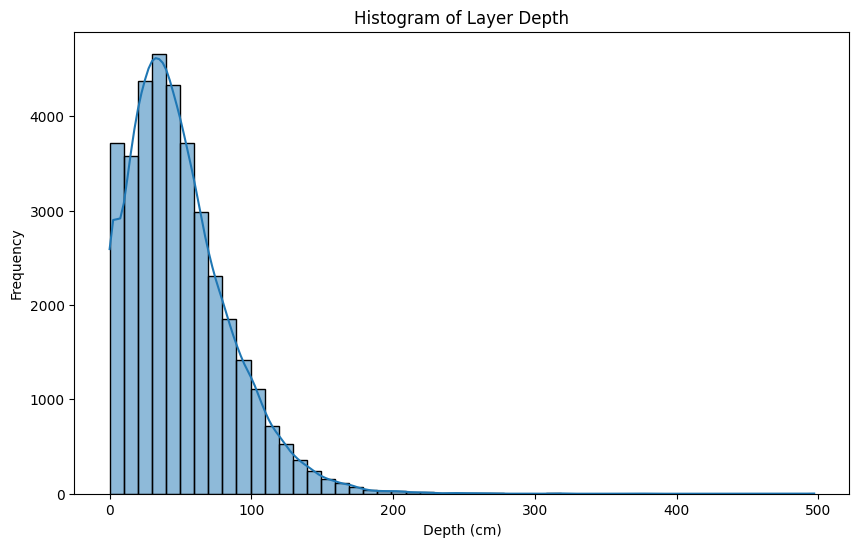

In [7]:
## Layer Depth

# Stats
# Number of layers
print(f"Number of layers: {len(layers_of_concern_df)}")
print(f"Number of layers with depth: {len(layers_of_concern_df[layers_of_concern_df['depth_top'].notna()])}")
# Stats
print(f"Average depth: {layers_of_concern_df['depth_top'].mean():.2f} cm")
print(f"Median depth: {layers_of_concern_df['depth_top'].median():.2f} cm")
print(f"Max depth: {layers_of_concern_df['depth_top'].max():.2f} cm")
print(f"Min depth: {layers_of_concern_df['depth_top'].min():.2f} cm")

# Visualizations
# Histogram of layer depth
plt.figure(figsize=(10, 6))
sns.histplot(layers_of_concern_df['depth_top'], bins=50, kde=True)
plt.title('Histogram of Layer Depth')
plt.xlabel('Depth (cm)')
plt.ylabel('Frequency')
plt.show()


Number of layers: 36409
Number of layers with thickness: 36409
Average thickness: 13.09 cm
Median thickness: 8.00 cm
Max thickness: 250.00 cm
Min thickness: 0.01 cm


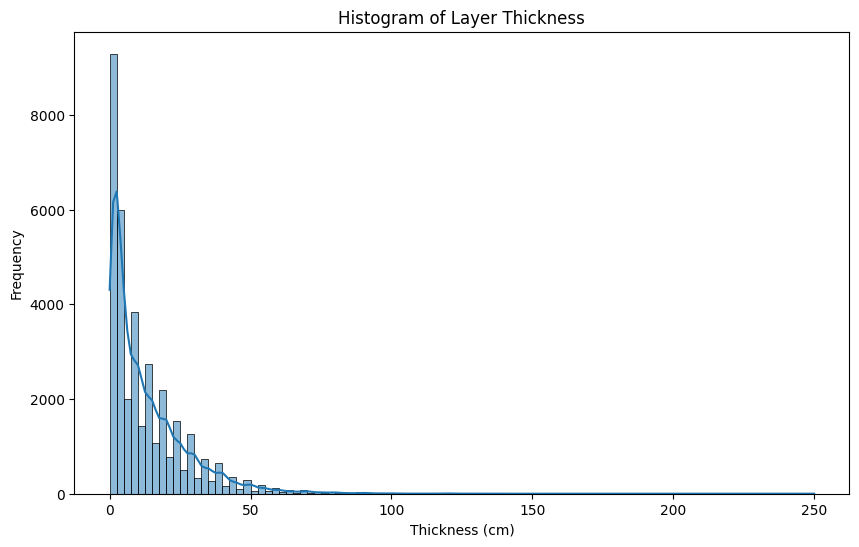

In [8]:
## Layer Thickness
# Stats
# Number of layers
print(f"Number of layers: {len(layers_of_concern_df)}")
print(f"Number of layers with thickness: {len(layers_of_concern_df[layers_of_concern_df['thickness'].notna()])}")
# Stats
print(f"Average thickness: {layers_of_concern_df['thickness'].mean():.2f} cm")
print(f"Median thickness: {layers_of_concern_df['thickness'].median():.2f} cm")
print(f"Max thickness: {layers_of_concern_df['thickness'].max():.2f} cm")
print(f"Min thickness: {layers_of_concern_df['thickness'].min():.2f} cm")

# Visualizations
# Histogram of layer thickness
plt.figure(figsize=(10, 6))
sns.histplot(layers_of_concern_df['thickness'], bins=100, kde=True)
plt.title('Histogram of Layer Thickness')
plt.xlabel('Thickness (cm)')
plt.ylabel('Frequency')
plt.show()


In [9]:
## Hand Hardness

# Stats
# Number of layers
print(f"Number of layers: {len(layers_of_concern_df)}")
print(f"Number of layers with hand hardness: {len(layers_of_concern_df[layers_of_concern_df['hardness'].notna()])}, {len(layers_of_concern_df[layers_of_concern_df['hardness'].notna()])/len(layers_of_concern_df):.2%}")

#Frequency of hand hardness
print(layers_of_concern_df['hardness'].value_counts())

#Visualizations
# Histogram of hand hardness


Number of layers: 36409
Number of layers with hand hardness: 33114, 90.95%
hardness
F      9726
4F     7540
1F     3414
P      2138
4F-    1711
K      1540
F+     1498
F-     1285
4F+    1091
1F-     881
1F+     652
P+      513
P-      397
I       329
K-      274
K+       61
I-       50
I+       14
Name: count, dtype: int64


In [10]:
## Wetness

# Stats
# Number of layers
print(f"Number of layers: {len(layers_of_concern_df)}")
print(f"Number of layers with wetness: {len(layers_of_concern_df[layers_of_concern_df['wetness'].notna()])}, {len(layers_of_concern_df[layers_of_concern_df['wetness'].notna()])/len(layers_of_concern_df):.2%}")

#Frequency of wetness
print(layers_of_concern_df['wetness'].value_counts())

#Visualizations
# Histogram of wetness


Number of layers: 36409
Number of layers with wetness: 9378, 25.76%
wetness
D      7154
M       998
D-M     647
M-W     225
W       224
V        60
W-V      32
S        19
V-S      19
Name: count, dtype: int64


In [15]:
# Grain Forms

# Stats
# Number of layers
print(f"Number of layers: {len(layers_of_concern_df)}")
print(f"Number of layers with primary grain form grain form: {len(layers_of_concern_df[layers_of_concern_df['grain_form_primary_grain_form'].notna()])}, {len(layers_of_concern_df[layers_of_concern_df['grain_form_primary_grain_form'].notna()])/len(layers_of_concern_df):.2%}")
print(f"Number of layers with primary grain form grain size: {len(layers_of_concern_df[layers_of_concern_df['grain_from_primary_grain_size'].notna()])}, {len(layers_of_concern_df[layers_of_concern_df['grain_from_primary_grain_size'].notna()])/len(layers_of_concern_df):.2%}")
print(f"Number of layers with secondary grain form grain form: {len(layers_of_concern_df[layers_of_concern_df['grain_form_secondary_grain_form'].notna()])}, {len(layers_of_concern_df[layers_of_concern_df['grain_form_secondary_grain_form'].notna()])/len(layers_of_concern_df):.2%}")

#Frequency of grain forms
grain_form_counts = layers_of_concern_df['grain_form_primary_grain_form'].value_counts()
grain_form_percentages = layers_of_concern_df['grain_form_primary_grain_form'].value_counts(normalize=True) * 100

# Combine counts and percentages
grain_form_stats = pd.DataFrame({
    'Count': grain_form_counts,
    'Percentage': grain_form_percentages
})
grain_form_stats['Percentage'] = grain_form_stats['Percentage'].apply(lambda x: f'{x:.2f}%')
print(grain_form_stats)

#Frequency of main grain forms (first two characters)
main_grain_form_counts = layers_of_concern_df['grain_form_primary_grain_form'].str[:2].value_counts()
main_grain_form_percentages = layers_of_concern_df['grain_form_primary_grain_form'].str[:2].value_counts(normalize=True) * 100

# Combine counts and percentages
main_grain_form_stats = pd.DataFrame({
    'Count': main_grain_form_counts,
    'Percentage': main_grain_form_percentages
})
main_grain_form_stats['Percentage'] = main_grain_form_stats['Percentage'].apply(lambda x: f'{x:.2f}%')
print('\nMain Grain Forms:')
print(main_grain_form_stats)

#Visualizations
# Tree map of primary grain form grain form, grouped by main grain form code

# Prepare data for hierarchical treemap: filter out NaN values
grain_form_data = layers_of_concern_df[layers_of_concern_df['grain_form_primary_grain_form'].notna()].copy()
grain_form_data['main_grain_form'] = grain_form_data['grain_form_primary_grain_form'].str[:2]

# Get counts for each grain form
grain_form_counts = grain_form_data['grain_form_primary_grain_form'].value_counts()

# Create hierarchical data structure for plotly treemap
# Each row represents a specific grain form with its parent (main grain form)
treemap_data = []
for grain_form, count in grain_form_counts.items():
    main_form = grain_form[:2]
    treemap_data.append({
        'main_grain_form': main_form,  # Parent group
        'grain_form': grain_form,  # Specific grain form (child)
        'count': count
    })

treemap_df = pd.DataFrame(treemap_data)

# Create hierarchical treemap with plotly
# The path parameter creates the hierarchy: main_grain_form -> grain_form
fig = px.treemap(
    treemap_df,
    path=['main_grain_form', 'grain_form'],  # Hierarchical path: parent -> child
    values='count',
    title='Treemap of Primary Grain Forms (Grouped by Main Grain Form Code)',
    color='main_grain_form',  # Color by parent group
    color_discrete_sequence=px.colors.qualitative.Set3,
    height=800
)

# Update traces to show labels with counts
fig.update_traces(
    textinfo='label+value',
    texttemplate='%{label}<br>%{value}',
    textfont_size=11,
    hovertemplate='<b>%{label}</b><br>Count: %{value}<extra></extra>'
)

fig.update_layout(
    font_size=12,
    title_font_size=16,
    title_x=0.5
)

fig.show()


Number of layers: 36409
Number of layers with primary grain form grain form: 33153, 91.06%
Number of layers with primary grain form grain size: 22636, 62.17%
Number of layers with secondary grain form grain form: 6075, 16.69%
                               Count Percentage
grain_form_primary_grain_form                  
FC                              7550     22.77%
FCxr                            3570     10.77%
FCso                            2996      9.04%
MFcr                            2894      8.73%
DH                              1792      5.41%
SH                              1790      5.40%
DF                              1723      5.20%
FCsf                            1258      3.79%
RG                              1033      3.12%
SHsu                             613      1.85%
PP                               597      1.80%
DFdc                             572      1.73%
IFrc                             568      1.71%
RGxf                             541      1.63%
SHxr  

## Pits on Crowns and Flanks

In [27]:
# Pit subsets
pits_on_crowns = []
pits_on_flanks = []
pits_on_crowns_and_flanks = []

for pit in all_pits:
    # Initialize all variables to None for each pit
    identified_layer_of_concern = None
    layer_of_concern_depth = None
    layer_of_concern_thickness = None
    layer_of_concern_hardness = None
    layer_of_concern_wetness = None
    layer_of_concern_grain_form_primary_grain_form = None
    layer_of_concern_grain_from_primary_grain_size = None
    layer_of_concern_grain_form_secondary_grain_form = None
    layer_of_concern_grain_from_secondary_grain_size = None
    
    # Check for layer of concern
    if pit.snow_profile.layers:
        for layer in pit.snow_profile.layers:
            if layer.layer_of_concern is True:
                identified_layer_of_concern = True
                layer_of_concern_depth = layer.depth_top[0] if layer.depth_top else None
                layer_of_concern_thickness = layer.thickness[0] if layer.thickness else None
                layer_of_concern_hardness = layer.hardness if layer.hardness else None
                layer_of_concern_wetness = layer.wetness if layer.wetness else None
                layer_of_concern_grain_form_primary_grain_form = layer.grain_form_primary.grain_form if layer.grain_form_primary else None
                layer_of_concern_grain_from_primary_grain_size = layer.grain_form_primary.grain_size_avg[0] if layer.grain_form_primary and layer.grain_form_primary.grain_size_avg else None
                layer_of_concern_grain_form_secondary_grain_form = layer.grain_form_secondary.grain_form if layer.grain_form_secondary else None
                layer_of_concern_grain_from_secondary_grain_size = layer.grain_form_secondary.grain_size_avg[0] if layer.grain_form_secondary and layer.grain_form_secondary.grain_size_avg else None
                break  # Only take the first layer of concern
    
    # Create dictionary with layer of concern info
    pit_dict = {
        'pit_id': pit.core_info.pit_id,
        'identified_layer_of_concern': identified_layer_of_concern,
        'layer_of_concern_depth': layer_of_concern_depth,
        'layer_of_concern_thickness': layer_of_concern_thickness,
        'layer_of_concern_hardness': layer_of_concern_hardness,
        'layer_of_concern_wetness': layer_of_concern_wetness,
        'layer_of_concern_grain_form_primary_grain_form': layer_of_concern_grain_form_primary_grain_form,
        'layer_of_concern_grain_from_primary_grain_size': layer_of_concern_grain_from_primary_grain_size,
        'layer_of_concern_grain_form_secondary_grain_form': layer_of_concern_grain_form_secondary_grain_form,
        'layer_of_concern_grain_from_secondary_grain_size': layer_of_concern_grain_from_secondary_grain_size,
    }
    
    # Pits near avalanches
    if pit.core_info.location.pit_near_avalanche_location == "crown":
        pits_on_crowns.append(pit_dict)
        pits_on_crowns_and_flanks.append(pit_dict)
    elif pit.core_info.location.pit_near_avalanche_location == "flank":
        pits_on_flanks.append(pit_dict)
        pits_on_crowns_and_flanks.append(pit_dict)

pits_on_crowns_df = pd.DataFrame(pits_on_crowns)
pits_on_flanks_df = pd.DataFrame(pits_on_flanks)
pits_on_crowns_and_flanks_df = pd.DataFrame(pits_on_crowns_and_flanks)



In [ ]:
## Stats

# Total Pits
print(f"Total Pits: {len(pit_df)}")
print(f"Number of Pits on Crowns: {len(pits_on_crowns_df)}, {len(pits_on_crowns_df)/len(pit_df):.2%}")
print(f"Number of Pits on Flanks: {len(pits_on_flanks_df)}, {len(pits_on_flanks_df)/len(pit_df):.2%}")
print(f"Number of Pits on Crowns and Flanks: {len(pits_on_crowns_and_flanks_df)}, {(len(pits_on_crowns_and_flanks_df))/len(pit_df):.2%}")

print("\nLayer of Concern Stats")
print(f"Pits on Crowns with Layer of Concern: {len(pits_on_crowns_df[pits_on_crowns_df['identified_layer_of_concern'] == True])}, {len(pits_on_crowns_df[pits_on_crowns_df['identified_layer_of_concern'] == True])/len(pits_on_crowns_df):.2%}")
print(f"Pits on Flanks with Layer of Concern: {len(pits_on_flanks_df[pits_on_flanks_df['identified_layer_of_concern'] == True])}, {len(pits_on_flanks_df[pits_on_flanks_df['identified_layer_of_concern'] == True])/len(pits_on_flanks_df):.2%}")
print(f"Pits on Crowns and Flanks with Layer of Concern: {len(pits_on_crowns_and_flanks_df[pits_on_crowns_and_flanks_df['identified_layer_of_concern'] == True])}, {len(pits_on_crowns_and_flanks_df[pits_on_crowns_and_flanks_df['identified_layer_of_concern'] == True])/len(pits_on_crowns_and_flanks_df):.2%}")


Total Pits: 50278
Number of Pits on Crowns: 795, 1.58%
Number of Pits on Flanks: 399, 0.79%
Number of Pits on Crowns and Flanks: 1194, 2.37%

Layer of Concern Stats
Pits on Crowns with Layer of Concern: 715, 89.94%
Pits on Flanks with Layer of Concern: 356, 89.22%
Pits on Crowns and Flanks with Layer of Concern: 1071, 89.70%


GRAIN FORM COMPARISON: CROWNS vs FLANKS

Total pits on crowns with layer of concern and grain form: 679
Total pits on flanks with layer of concern and grain form: 329

--------------------------------------------------------------------------------
MAIN GRAIN FORM FREQUENCY - CROWNS
--------------------------------------------------------------------------------
                 Count Percentage
main_grain_form                  
FC                 407     59.94%
SH                  75     11.05%
DH                  54      7.95%
MF                  52      7.66%
DF                  40      5.89%
PP                  20      2.95%
RG                  20      2.95%
IF                  11      1.62%

--------------------------------------------------------------------------------
MAIN GRAIN FORM FREQUENCY - FLANKS
--------------------------------------------------------------------------------
                 Count Percentage
main_grain_form                  
FC                 169     51

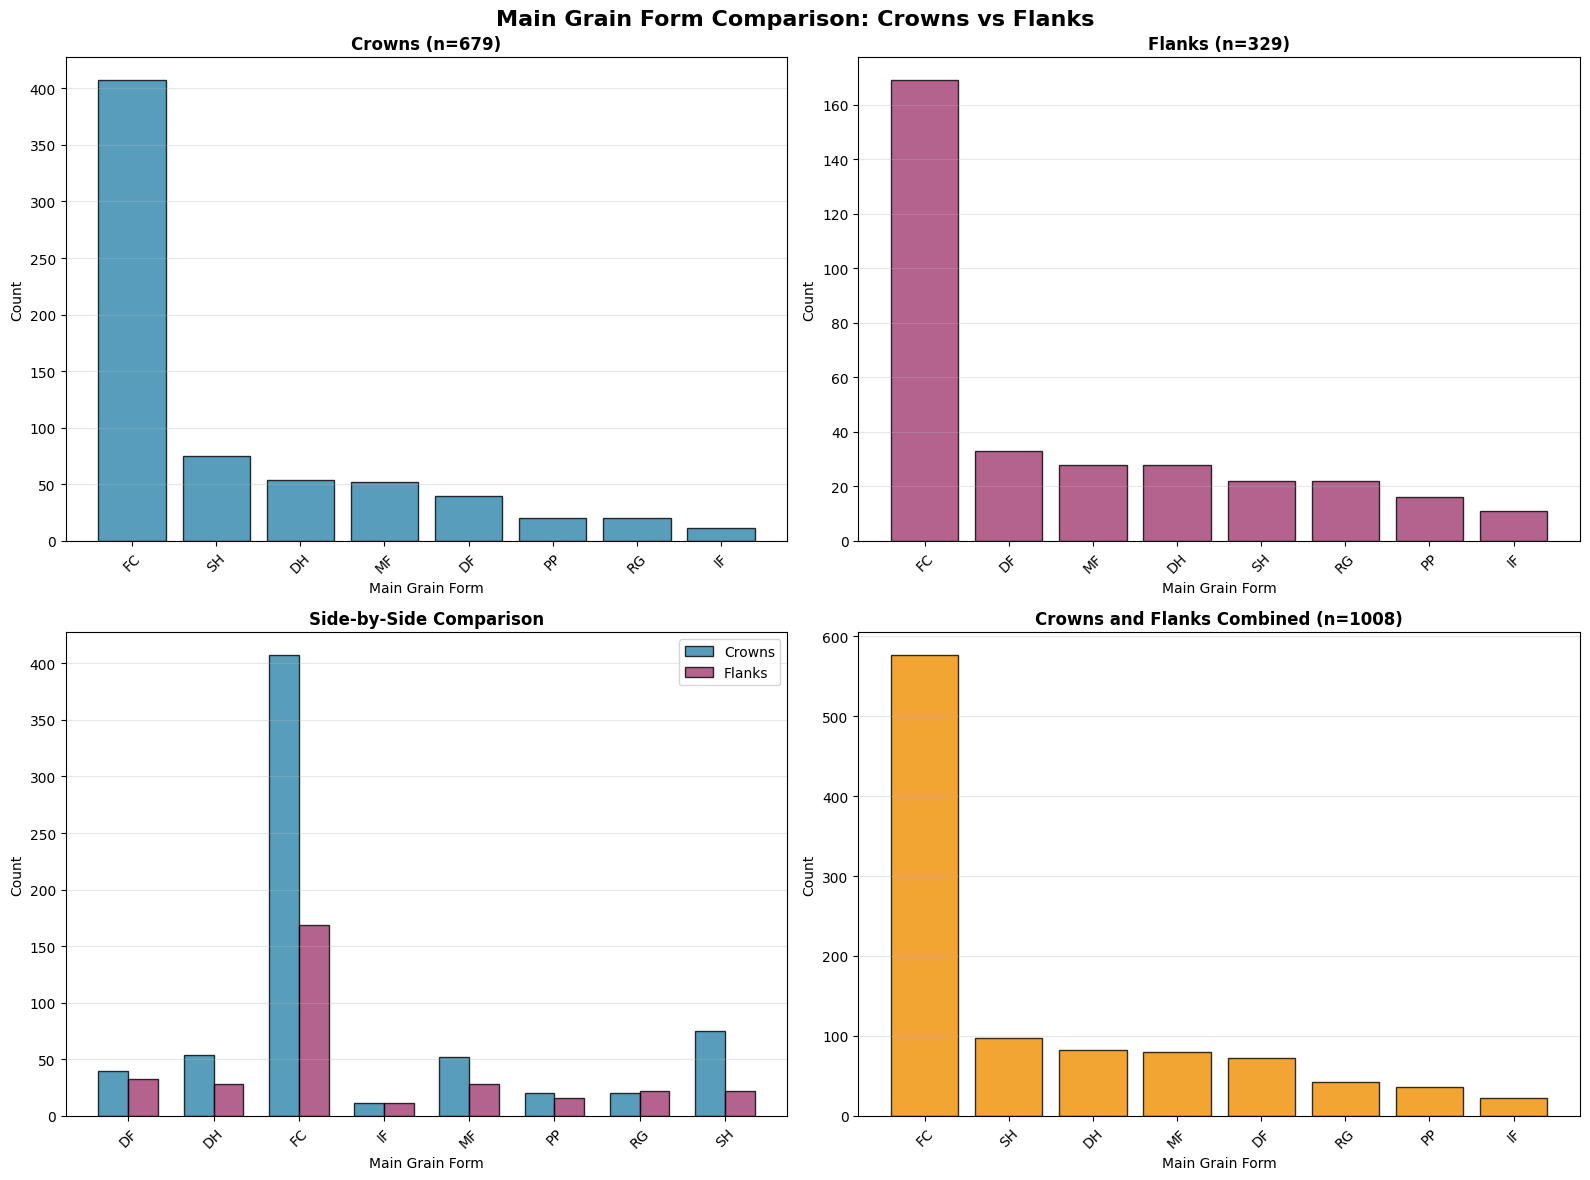

In [31]:
# Grain Form Comparison

# Extract main grain forms (first 2 characters) for each dataset
# Filter to only include pits with identified layer of concern and valid grain form
crowns_with_grain = pits_on_crowns_df[
    (pits_on_crowns_df['identified_layer_of_concern'] == True) & 
    (pits_on_crowns_df['layer_of_concern_grain_form_primary_grain_form'].notna())
].copy()
crowns_with_grain['main_grain_form'] = crowns_with_grain['layer_of_concern_grain_form_primary_grain_form'].str[:2]

flanks_with_grain = pits_on_flanks_df[
    (pits_on_flanks_df['identified_layer_of_concern'] == True) & 
    (pits_on_flanks_df['layer_of_concern_grain_form_primary_grain_form'].notna())
].copy()
flanks_with_grain['main_grain_form'] = flanks_with_grain['layer_of_concern_grain_form_primary_grain_form'].str[:2]

crowns_and_flanks_with_grain = pits_on_crowns_and_flanks_df[
    (pits_on_crowns_and_flanks_df['identified_layer_of_concern'] == True) & 
    (pits_on_crowns_and_flanks_df['layer_of_concern_grain_form_primary_grain_form'].notna())
].copy()
crowns_and_flanks_with_grain['main_grain_form'] = crowns_and_flanks_with_grain['layer_of_concern_grain_form_primary_grain_form'].str[:2]

# Calculate frequency statistics for each dataset
crowns_grain_counts = crowns_with_grain['main_grain_form'].value_counts()
crowns_grain_percentages = crowns_with_grain['main_grain_form'].value_counts(normalize=True) * 100

flanks_grain_counts = flanks_with_grain['main_grain_form'].value_counts()
flanks_grain_percentages = flanks_with_grain['main_grain_form'].value_counts(normalize=True) * 100

crowns_and_flanks_grain_counts = crowns_and_flanks_with_grain['main_grain_form'].value_counts()
crowns_and_flanks_grain_percentages = crowns_and_flanks_with_grain['main_grain_form'].value_counts(normalize=True) * 100

# Print comparison statistics
print("="*80)
print("GRAIN FORM COMPARISON: CROWNS vs FLANKS")
print("="*80)
print(f"\nTotal pits on crowns with layer of concern and grain form: {len(crowns_with_grain)}")
print(f"Total pits on flanks with layer of concern and grain form: {len(flanks_with_grain)}")

print("\n" + "-"*80)
print("MAIN GRAIN FORM FREQUENCY - CROWNS")
print("-"*80)
crowns_stats = pd.DataFrame({
    'Count': crowns_grain_counts,
    'Percentage': crowns_grain_percentages
})
crowns_stats['Percentage'] = crowns_stats['Percentage'].apply(lambda x: f'{x:.2f}%')
print(crowns_stats)

print("\n" + "-"*80)
print("MAIN GRAIN FORM FREQUENCY - FLANKS")
print("-"*80)
flanks_stats = pd.DataFrame({
    'Count': flanks_grain_counts,
    'Percentage': flanks_grain_percentages
})
flanks_stats['Percentage'] = flanks_stats['Percentage'].apply(lambda x: f'{x:.2f}%')
print(flanks_stats)

# Create comparison DataFrame
all_grain_forms = sorted(set(list(crowns_grain_counts.index) + list(flanks_grain_counts.index)))
comparison_data = []
for gf in all_grain_forms:
    crowns_count = crowns_grain_counts[gf] if gf in crowns_grain_counts.index else 0
    crowns_pct = crowns_grain_percentages[gf] if gf in crowns_grain_percentages.index else 0
    flanks_count = flanks_grain_counts[gf] if gf in flanks_grain_counts.index else 0
    flanks_pct = flanks_grain_percentages[gf] if gf in flanks_grain_percentages.index else 0
    
    comparison_data.append({
        'Main_Grain_Form': gf,
        'Crowns_Count': crowns_count,
        'Crowns_Percentage': f'{crowns_pct:.2f}%' if crowns_pct > 0 else '0.00%',
        'Flanks_Count': flanks_count,
        'Flanks_Percentage': f'{flanks_pct:.2f}%' if flanks_pct > 0 else '0.00%'
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "-"*80)
print("SIDE-BY-SIDE COMPARISON: CROWNS vs FLANKS")
print("-"*80)
print(comparison_df.to_string(index=False))

# Separate analysis for crowns_and_flanks dataset
print("\n\n" + "="*80)
print("GRAIN FORM ANALYSIS: CROWNS AND FLANKS COMBINED")
print("="*80)
print(f"\nTotal pits on crowns and flanks with layer of concern and grain form: {len(crowns_and_flanks_with_grain)}")

print("\n" + "-"*80)
print("MAIN GRAIN FORM FREQUENCY - CROWNS AND FLANKS")
print("-"*80)
crowns_and_flanks_stats = pd.DataFrame({
    'Count': crowns_and_flanks_grain_counts,
    'Percentage': crowns_and_flanks_grain_percentages
})
crowns_and_flanks_stats['Percentage'] = crowns_and_flanks_stats['Percentage'].apply(lambda x: f'{x:.2f}%')
print(crowns_and_flanks_stats)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Main Grain Form Comparison: Crowns vs Flanks', fontsize=16, fontweight='bold')

# Plot 1: Crowns frequency
axes[0, 0].bar(crowns_grain_counts.index, crowns_grain_counts.values, color='#2E86AB', alpha=0.8, edgecolor='black')
axes[0, 0].set_title(f'Crowns (n={len(crowns_with_grain)})', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Main Grain Form', fontsize=10)
axes[0, 0].set_ylabel('Count', fontsize=10)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Flanks frequency
axes[0, 1].bar(flanks_grain_counts.index, flanks_grain_counts.values, color='#A23B72', alpha=0.8, edgecolor='black')
axes[0, 1].set_title(f'Flanks (n={len(flanks_with_grain)})', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Main Grain Form', fontsize=10)
axes[0, 1].set_ylabel('Count', fontsize=10)
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Side-by-side comparison
x = np.arange(len(all_grain_forms))
width = 0.35
axes[1, 0].bar(x - width/2, [crowns_grain_counts[gf] if gf in crowns_grain_counts.index else 0 for gf in all_grain_forms], 
               width, label='Crowns', color='#2E86AB', alpha=0.8, edgecolor='black')
axes[1, 0].bar(x + width/2, [flanks_grain_counts[gf] if gf in flanks_grain_counts.index else 0 for gf in all_grain_forms], 
               width, label='Flanks', color='#A23B72', alpha=0.8, edgecolor='black')
axes[1, 0].set_title('Side-by-Side Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Main Grain Form', fontsize=10)
axes[1, 0].set_ylabel('Count', fontsize=10)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(all_grain_forms, rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Crowns and Flanks Combined
axes[1, 1].bar(crowns_and_flanks_grain_counts.index, crowns_and_flanks_grain_counts.values, 
               color='#F18F01', alpha=0.8, edgecolor='black')
axes[1, 1].set_title(f'Crowns and Flanks Combined (n={len(crowns_and_flanks_with_grain)})', 
                     fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Main Grain Form', fontsize=10)
axes[1, 1].set_ylabel('Count', fontsize=10)
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## Pits with Stability Test Results

In [13]:
pits_with_CT_results = []
pits_with_ECT_results = []
pits_with_PST_results = []


for pit in all_pits:
    # Stability Tests
    if len(pit.stability_tests.CT) > 0:
        pits_with_CT_results.append(pit)
    if len(pit.stability_tests.ECT) > 0:
        pits_with_ECT_results.append(pit)
    if len(pit.stability_tests.PST) > 0:
        pits_with_PST_results.append(pit)
